In [1]:
using Gen
using Distributions
using Random
using Plots
using Statistics

In [15]:
# Some constants
const dt = 0.1         # Simulation fidelty
const LANDMARK_X = 3.0 # Landmark position
const LANDMARK_Y = 3.0

3.0

In [ ]:
@gen function robot_localization_model(
    dt:Float64,
    controls::Matrix{Float64},
    T::Int,                    
    sigma_v::Float64,          
    sigma_omega::Float64,       
    sigma_obs::Float64         
)
    # Initial pose
    x = @trace(normal(7.5, 1.0), :x0)          # robot position
    y = @trace(normal(7.5, 1.0), :y0)
    theta = @trace(normal(0.0, 0.5), :theta0)  # robot rotation
    
    # Range to landmark
    range0 = sqrt((LANDMARK_X - x)^2 + (LANDMARK_Y - y)^2)
    @trace(normal(range0, sigma_obs), (:obs, 0))
    
    for t in 1:T        
        # Odometry readings will be noisy. We add a simplified noise model that adds some gaussian noise
        v_noisy = @trace(normal(controls[t, 1], sigma_v), (:v_noise, t))
        omega_noisy = @trace(normal(controls[t, 2], sigma_omega), (:omega_noise, t))
        
        # Update the pose and range to landmakr
        theta = rem2pi(theta + omega_noisy * dt, RoundNearest)
        x = x + v_noisy * cos(theta) * dt
        y = y + v_noisy * sin(theta) * dt
        expected_range = sqrt((LANDMARK_X - x)^2 + (LANDMARK_Y - y)^2)
        @trace(normal(expected_range, sigma_obs), (:obs, t))
    end
    
    return (x, y, theta)
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Matrix{Float64}, Int64, Float64, Float64, Float64], false, Union{Nothing, Some{Any}}[nothing, nothing, nothing, nothing, nothing, nothing], Main.var"##robot_localization_model#284", Bool[0, 0, 0, 0, 0, 0], false)

In [ ]:
# Example impulse control generation. In a real-world setting we would first collect this data from the robot
# controls and then read it into the program rather than simulate it.
Random.seed!(69)

T = 500
sigma_v = 0.15
sigma_omega = 0.1 
sigma_obs = 0.3
controls = zeros(T, 2)
turn_bias = 0.0

for t in 1:T
    # Occasionally change turn direction
    if t % 7 == 1 || rand() < 0.15
        turn_bias = randn() * 1.5
    end
    v = 0.35 + 0.1 * randn()
    omega = turn_bias + 0.8 * randn()
    controls[t, 1] = clamp(v, 0.2, 0.5)
    controls[t, 2] = clamp(omega, -2.0, 2.0)
end

In [ ]:
# Generate a trace from the model
(trace, _) = generate(robot_localization_model, (dt, controls, T, sigma_v, sigma_omega, sigma_obs))

# Extract ground truth initial state
x0_true = trace[:x0]
y0_true = trace[:y0]
theta0_true = trace[:theta0]

# Extract observations
observations = [trace[(:obs, t)] for t in 0:T]

println("Initial pose")
println("x0 = $(round(x0_true, digits=3))")
println("y0 = $(round(y0_true, digits=3))")
println("θ0 = $(round(theta0_true, digits=3)) rad")

println("\nObservations (range to landmark)")
for t in 0:50:T
    println("t=$t: range = $(round(observations[t+1], digits=2)) m")
end


Initial pose
x0 = 8.783
y0 = 7.362
θ0 = -0.631 rad

Observations (range to landmark)
t=0: range = 7.15 m
t=50: range = 6.44 m
t=100: range = 5.07 m
t=150: range = 3.98 m
t=200: range = 1.55 m
t=250: range = 2.61 m
t=300: range = 2.49 m
t=350: range = 2.5 m
t=400: range = 2.49 m
t=450: range = 3.32 m
t=500: range = 2.66 m


In [33]:
# A naive function to reconstruct trajectory from observations. This just
# uses noisy observations, accumulating error.
function simulate_trajectory(trace, controls, T)
    # List of estimated poses 
    poses = zeros(T+1, 3)
    
    # Initial pose
    x = trace[:x0]
    y = trace[:y0]
    theta = trace[:theta0]
    poses[1, :] = [x, y, theta]
    
    for t in 1:T
        theta = rem2pi(theta + trace[(:omega_noise, t)] * dt, RoundNearest)
        x = x + trace[(:v_noise, t)] * cos(theta) * dt
        y = y + trace[(:v_noise, t)] * sin(theta) * dt
        poses[t+1, :] = [x, y, theta]
    end
    
    return poses
end

simulate_trajectory (generic function with 2 methods)

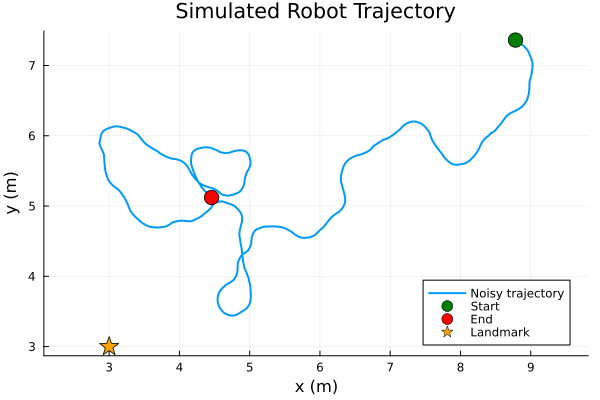

In [35]:
true_poses = simulate_trajectory(trace, controls, T)

# Plot the noisy trajectory
p = plot(
    true_poses[:, 1], true_poses[:, 2],
    label="Noisy trajectory",
    xlabel="x (m)", ylabel="y (m)",
    title="Simulated Robot Trajectory",
    linewidth=2,
    aspect_ratio=:equal,
    legend=:bottomright
)

# Mark start, end, and landmark
scatter!(p, [true_poses[1, 1]], [true_poses[1, 2]], label="Start", markersize=8, color=:green)
scatter!(p, [true_poses[end, 1]], [true_poses[end, 2]], label="End", markersize=8, color=:red)
scatter!(p, [LANDMARK_X], [LANDMARK_Y], label="Landmark", markersize=10, markershape=:star5, color=:orange)

display(p)